Text(0.5,1,u'MCRO.csv')

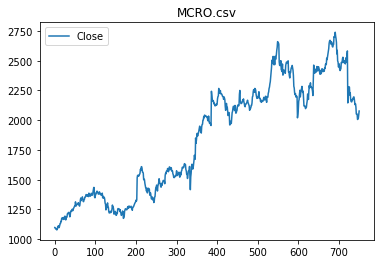

In [381]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np, numpy.random
import cvxopt as opt
from cvxopt import blas, solvers
import os, random

assets = [] # 3 random assets' expected return
# read a random file
rand_stocks = []
rand_stock = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock)
df1 = pd.read_csv('stock_dfs/'+rand_stock, usecols=['Date', 'Close'])
# df1 = pd.read_csv('stock_dfs/RRS.csv', usecols=['Date', 'Close'])
df1.plot()
plt.title(rand_stock)
# df1.head()

In [382]:
## use first half of 3 stocks to find expected return and covariances
# asset's first half expected return function
def half_expected_return(df, assets):
    df = df[:-len(df)/2] # drop second half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets.append(returns.mean())
    
    return returns
returns1 = half_expected_return(df1, assets)
# print returns1
print assets

[0.0014972640276812684]


Text(0.5,1,u'SGRO.csv')

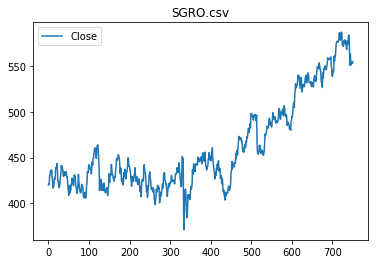

In [383]:
rand_stock2 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock2)
df2 = pd.read_csv('stock_dfs/'+rand_stock2, usecols=['Date', 'Close'])
# df2 = pd.read_csv('stock_dfs/III.csv', usecols=['Date', 'Close'])
df2.plot()
plt.title(rand_stock2)
# df2.head()

In [384]:
returns2 = half_expected_return(df2, assets)
print assets

[0.0014972640276812684, 5.9523943706986714e-05]


[0.0014972640276812684, 5.9523943706986714e-05, 0.0004291364378547046]


Text(0.5,1,u'NG..csv')

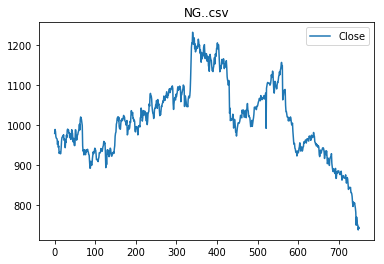

In [385]:
rand_stock3 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock3)
df3 = pd.read_csv('stock_dfs/'+rand_stock3, usecols=['Date', 'Close'])
# df3 = pd.read_csv('stock_dfs/ADM.csv', usecols=['Date', 'Close'])
returns3 = half_expected_return(df3, assets)
print assets
df3.plot()
plt.title(rand_stock3)

In [386]:
# find covariance of 3 assets
C = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C

[[2.82994006e-04 1.17539387e-04 4.26600299e-05]
 [1.17539387e-04 2.43409713e-04 7.60672779e-05]
 [4.26600299e-05 7.60672779e-05 1.37158790e-04]]


     pcost       dcost       gap    pres   dres
 0: -6.6309e-04 -1.0015e+00  1e+00  2e-16  2e+00
 1: -6.6383e-04 -1.1497e-02  1e-02  8e-17  3e-02
 2: -7.2989e-04 -1.5973e-03  9e-04  0e+00  2e-03
 3: -1.4760e-03 -1.7364e-03  3e-04  7e-16  3e-04
 4: -1.4966e-03 -1.4997e-03  3e-06  2e-16  3e-06
 5: -1.4973e-03 -1.4973e-03  3e-08  1e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.9994e-04 -1.0014e+00  1e+00  3e-16  2e+00
 1: -6.0066e-04 -1.1412e-02  1e-02  1e-16  2e-02
 2: -6.6405e-04 -1.5046e-03  8e-04  6e-17  2e-03
 3: -1.3464e-03 -1.5676e-03  2e-04  6e-16  9e-05
 4: -1.3554e-03 -1.3579e-03  3e-06  5e-17  1e-06
 5: -1.3558e-03 -1.3558e-03  3e-08  1e-16  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.3680e-04 -1.0013e+00  1e+00  6e-17  2e+00
 1: -5.3750e-04 -1.1328e-02  1e-02  1e-16  2e-02
 2: -5.9857e-04 -1.4126e-03  8e-04  1e-16  2e-03
 3: -1.1830e-03 -1.3959e-03  2e-04  6e-16  9e-19
 4: -1.2121e-03 -1.2161e

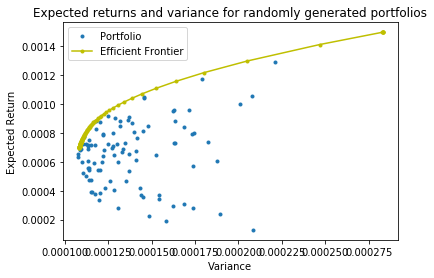

In [387]:
## find efficient frontier
# generate random portfolio, see random_portfolio notebook
np.random.seed(2) # fixed random seed
n_portfolio = 100 # number of portfolios
n_asset = len(assets) # number of assets 3
rand_matrix = np.random.random((n_portfolio, n_asset)) # generate random matrix
portfolio = np.zeros((n_portfolio, n_asset)) # create portfolios
i = 0
for row in rand_matrix: # each portfolio sum up to 1
    row_sum = np.sum(row)
    j = 0
    for col in row:
        portfolio[i][j] = col/row_sum
        j += 1
    i += 1
E = np.dot(portfolio, assets) # find expected return of each portfolio
variance = np.zeros((n_portfolio, 1)) # find variance of all portfolio
i = 0
for row in portfolio:
    variance[i] = np.dot(np.dot(row, C), row.T)
    i += 1
    
fig, ax = plt.subplots()
plotfolios = ax.plot(variance, E, 'o', markersize=3, label='Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for randomly generated portfolios')

N = 100
points = [t for t in range(N)] # find max return for 100 points
S = opt.matrix(C)
q = opt.matrix(assets, (3, 1)) # mean return of 3 assets

G = -opt.matrix(np.eye(n_asset)) # all 3 portions >= 0
h = opt.matrix(0.0, (n_asset, 1))
A = opt.matrix(1.0, (1, n_asset)) # all 3 portions sum to 1
b = opt.matrix(1.0)

portfolios = [solvers.qp(x*S, -q, G, h, A, b)['x'] for x in points]
returns = [blas.dot(q, x) for x in portfolios] # for each efficient portfolio
risks = [blas.dot(x, S*x) for x in portfolios]

frontier = ax.plot(risks, returns, 'y-o', markersize=3, label='Efficient Frontier')
ax.legend(loc='best')

In [388]:
assets2 = []
# take second half of assets
def half2_expected_return(df, assets):
    df = df[len(df)/2:] # drop first half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets2.append(returns.mean())
    return returns
returns1 = half2_expected_return(df1, assets2)
print assets2
# print returns1

[-0.00011429080683245983]


In [389]:
returns2 = half2_expected_return(df2, assets2)
print assets2

[-0.00011429080683245983, 0.0005095755419275935]


In [390]:
returns3 = half2_expected_return(df3, assets2)
print assets2

[-0.00011429080683245983, 0.0005095755419275935, -0.0013074415076223369]


In [391]:
# find covariance of 3 assets second half
C2 = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C2

[[3.61857964e-04 2.65991582e-05 3.56376394e-05]
 [2.65991582e-05 1.06287742e-04 3.73001917e-05]
 [3.56376394e-05 3.73001917e-05 1.61149327e-04]]


Text(0.5,1,u'Expected returns and variance for naive portfolios')

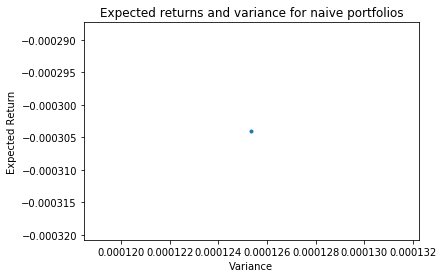

In [392]:
n_portfolio = 1 # number of portfolios
n_asset = len(assets2) # number of assets 3
naive = np.full((n_portfolio, n_asset), 1.0/3) # generate Naive Diversification
E = np.dot(naive, assets2) # find expected return of each portfolio
variance2 = np.dot(np.dot(row, C2), row.T) # find variance of all portfolio
variance2

fig2, ax2 = plt.subplots()
plotfolios2 = ax2.plot(variance2, E, 'o', markersize=3, label='Naive Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for naive portfolios')

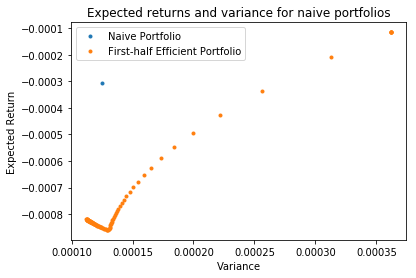

In [393]:
# apply first half efficient portfolios to second half
qn = opt.matrix(assets2, (3, 1))
Sn = opt.matrix(C2)
ef1 = [blas.dot(qn, x) for x in portfolios]
risks1 = [blas.dot(x, Sn*x) for x in portfolios]
ax2.plot(risks1, ef1, 'o', markersize=3, label='First-half Efficient Portfolio')
ax2.legend(loc='best')
fig2